# Initialisation

In [221]:
import write_files as wf
import ihp
import lpse_data as ld
import matplotlib.pyplot as plt
import numpy as np
import copy
from time import time as stopwatch
from calc_inputs import *

# Ipython magic features
%load_ext autoreload
%autoreload 2
  
# LPSE class
lpse = ld.lpse_case()
lpse.dfp = './data/lpse.' # Data file prefix
lpse.verbose = False # Show prints
lpse.np = 1 # Number of processors
lpse.bin = '/home/space/phrfqm/lpse-3.2.11/bin/lpse_cpu' # Binary

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Case setup

In [222]:
jc = wf.job_control()
jc.version = '3.2.11' 
jc.seed = 1 # 0 for random, otherwise fixed seed
jc.resources.heartbeatInterval = 0.1 # minutes
jc.verbose = 2
jc.isRelativistic = 'true'
lpse.add_class(jc)

In [223]:
gr = wf.gridding()
gr.grid.sizes = 1.0 # microns
gr.grid.nodes = 10
gr.grid.antiAliasing.isAutomatic = 'false'
gr.grid.antiAliasing.range = 0.333
lpse.add_class(gr)

In [224]:
cm = wf.components()
cm.laser.enable = 'true'
cm.raman.enable = 'true'
cm.lw.enable = 'true'
lpse.add_class(cm)

In [225]:
tc = wf.temporal_control()
tc.simulation.samplePeriod = 0.05 # ps
tc.simulation.time.end = 0.5 # ps
lpse.add_class(tc)

In [226]:
io = wf.io_control()
io.grid.downSampleFactors = 1 # Spatial
io.laser.save.E0.z = lpse.dfp + 'E0_z'
io.raman.save.E0.z = lpse.dfp + 'E1_z'
io.lw.save.pots = lpse.dfp + 'pots'
io.raman.save.S0.x = lpse.dfp + 'S1_x'
lpse.add_class(io)

In [227]:
pp = wf.physical_parameters()
pp.physical.Z = 1.0
pp.physical.Te = 4.5 # keV
pp.physical.Ti = 4.5 # keV
pp.physical.MiOverMe = 1836.15
# pp.lw.envelopeDensity = 0.15
lpse.plasmaFrequencyDensity = 0.15
pp.densityProfile.shape = 'linear'
pp.densityProfile.geometry = 'cartesian'
pp.densityProfile.NminOverNc = 0.15
pp.densityProfile.NmaxOverNc = 0.15
pp.densityProfile.NminLocation = '-50 0 0'
pp.densityProfile.NmaxLocation = '50 0 0'
lpse.add_class(pp)

In [228]:
lc = wf.light_control()
lc.laser.wavelength = 0.351 # microns
lc.laser.pumpDepletion.SRS.enable = 'false'
lc.laser.evolution.Labc = 0 # microns
lc.laser.evolution.Loff = 0 # microns
lc.laser.solver = 'static'
lc.laser.static.computeFieldInXSpace.enable = 'false'
lc.laser.maxRamanStepsPerStep = 1
lc.raman.sourceTerm.lw.enable = 'true'
lc.raman.evolution.Labc = 0
lc.raman.evolution.Loff = 0 
lc.raman.maxLaserStepsPerStep = 1

# fd solver
# lc.laser.solver = 'fd'
# lc.laser.evolution.solverOrder = 6
# lc.laser.evolution.dtFraction = 0.95
# lc.raman.solver = 'fd'
# lc.raman.evolution.solverOrder = 6
# lc.raman.evolution.dtFraction = 0.95

# spectral solver
lc.raman.solver = 'spectral'
lc.raman.spectral.dt = 2e-6
# lc.laser.solver = 'spectral'
# lc.laser.spectral.dt = 2e-6

lpse.add_class(lc)

In [229]:
ls = wf.light_source()
ls.laser.nBeams = 1
ls.laser.intensity = ['2.0e+15'] # W/cm^2
ls.laser.phase = [0] # degrees
ls.laser.polarization = [90] # degrees
ls.laser.direction = ['1 0 0']
ls.laser.frequencyShift = [0]
ls.laser.group = [0]
ls.laser.evolution.source = ['min.x']
ls.laser.evolution.offset = ['0 0 0'] # microns
ls.laser.evolution.width = [0] # Half-width at 1/e of sgauss [um]
ls.laser.evolution.sgOrder = [4]
ls.raman.nBeams = 0
ls.raman.intensity = ['8.0e+10'] # W/cm^2
ls.raman.phase = [0] # degrees
ls.raman.polarization = [90] # degrees
ls.raman.direction = ['-1 0 0']
ls.raman.frequencyShift = [0]
ls.raman.group = [0]
ls.raman.evolution.source = ['max.x']
ls.raman.evolution.offset = ['0 0 0'] # microns
ls.raman.evolution.width = [0] # Half-width at 1/e of sgauss [um]
ls.raman.evolution.sgOrder = [4]
lpse.add_class(ls)

In [230]:
lwc = wf.lw_control()
lwc.lw.SRS.enable = 'true'
lwc.lw.spectral.dt = 2e-4 # ps
lwc.lw.Labc = 0 # microns
lwc.lw.noise.enable = 'false'
lwc.lw.noise.isCalculated = 'false'
lwc.lw.noise.amplitude = 1e-10
lwc.lw.collisionalDampingRate = 0.0
lwc.lw.maxLightStepsPerStep = 1
lwc.lw.__dict__['collisionalDampingRate.isCalculated'] = 'false'
lwc.lw.landauDamping.enable = 'true'
lwc.lw.landauDamping.lowerThreshold = 0.0
lwc.lw.kFilter.enable = 'true'
lwc.lw.kFilter.scale = 1.2
lpse.add_class(lwc)

In [231]:
ins = wf.instrumentation()
ins.metrics.enable = 'true'
ins.metrics.file = lpse.dfp + 'metrics'
ins.metrics.samplePeriod = 0.05 # ps
lpse.add_class(ins)

In [232]:
pert = wf.initial_perturbation()
pert.initialPerturbation.enable = 'true'
pert.initialPerturbation.field = 'E1_z'
pert.initialPerturbation.type = 'planeWave'
pert.initialPerturbation.wavelength = 1 # set after wavematching
pert.initialPerturbation.direction = '[-1 0 0]'
pert.initialPerturbation.envelopeSize = '[0 0 0]' # infinite
pert.initialPerturbation.envelopeOffset = '[0 0 0]'
pert.initialPerturbation.amplitude = 1 # set after wavematching
lpse.add_class(pert)

# Theoretical SRS growth rate and input calcs

In [233]:
# Adjust temperature and density slightly to get better wavelength matching
eps = np.finfo(np.float64).eps
max_iter = 20; minints = 2; disp = False; infl = False
ihp.rhoT_adjust(lpse,tol=4*eps,max_iter=max_iter,minints=minints,infl=infl,disp=disp)

Optimised rho and T: [0.15  4.918]


In [254]:
# Theory results
gamma, gamma0, k, dk = ihp.srs_theory(lpse,inflation=infl,dispfun=disp,verbose=True)
print(k)

Using 300 cells.
LW envelope density is: 0.1998
[[16.50693817 -7.07440207 23.58134024]]
[0.9221334426225304, -0.3952000468382266, 1.317333489460757] 17900812.840967484
Frequency matching error: -8.075e-13
Wavenumber matching error: 0.000e+00
Theory undamped SRS growth rate = 3.439e-03
Theory Landau damped SRS growth rate = 1.524e-03
[ 0.92213344 -0.39520005  1.31733349]


In [235]:
# Match domain size to wavelength integer multiples
cells_per_wvl = 40
ihp.wavelength_matching(lpse,k,tol=4*eps,max_iter=max_iter,minints=minints,cells_per_wvl=cells_per_wvl)

iter: 0; ints: [2 2 2]; rel-err: 9.333e+00
iter: 1; ints: [2 2 3]; rel-err: 7.619e+00
iter: 2; ints: [3 2 3]; rel-err: 7.333e+00
iter: 3; ints: [3 2 4]; rel-err: 5.333e+00
iter: 4; ints: [3 2 5]; rel-err: 4.762e+00
iter: 5; ints: [4 2 5]; rel-err: 3.333e+00
iter: 6; ints: [4 2 6]; rel-err: 1.905e+00
iter: 7; ints: [5 2 6]; rel-err: 2.286e+00
iter: 8; ints: [5 2 7]; rel-err: 9.524e-01
iter: 9; ints: [5 3 7]; rel-err: 6.000e+00
iter: 10; ints: [5 3 8]; rel-err: 5.714e+00
iter: 11; ints: [6 3 8]; rel-err: 4.000e+00
iter: 12; ints: [6 3 9]; rel-err: 2.857e+00
iter: 13; ints: [7 3 9]; rel-err: 2.000e+00
iter: 14; ints: [ 7  3 10]; rel-err: 3.277e-14
iter: 15; ints: [ 8  3 10]; rel-err: 2.857e+00
iter: 16; ints: [ 8  3 11]; rel-err: 2.857e+00
iter: 17; ints: [ 8  4 11]; rel-err: 4.667e+00
iter: 18; ints: [ 8  4 12]; rel-err: 3.810e+00
iter: 19; ints: [ 9  4 12]; rel-err: 2.667e+00
Tolerance not met, using min error at iter 14.

Final normalised values: [47.696 47.696 47.696]
Final wavelength

In [236]:
# Set LW envelope density and spectral timesteps
freqs = bsrs_lw_envelope(lpse,cells_per_wvl=cells_per_wvl,dispfun=disp)
print(freqs)
print(k)
spectral_dt(lpse,freqs,dt_frac=0.99)

[1.0, 0.5530397734503885, 0.44696022655041906]
[ 0.92213344 -0.39520005  1.31733349]


# Run case and get LPSE SRS growth rate

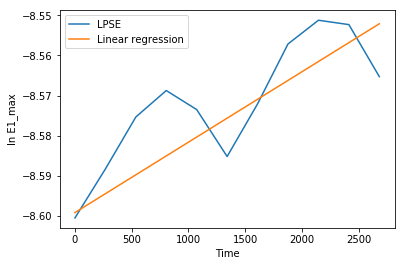

LPSE SRS growth rate is 1.755e-05
Undamped theory SRS growth rate is 3.439e-03
Landau damped theory SRS growth rate is 1.524e-03
LPSE relative error = -98.848%
Time taken: 22.698 s


In [255]:
if lwc.lw.landauDamping.enable == 'true':
  ld = True
else:
  ld = False
t1 = stopwatch()
pfit = ihp.srs_growth_error(lpse,gamma,gamma0,ld=ld)
t2 = stopwatch()
print(f'Time taken: {t2-t1:0.3f} s')

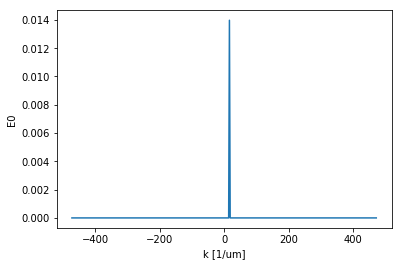

16.506699999999967


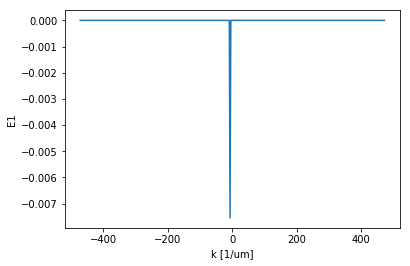

-7.074300000000051


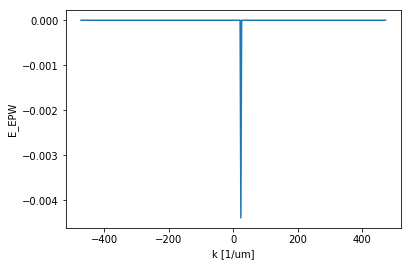

23.58099999999996


In [247]:
# Check E field of waves
lpse.fields(kspace=True)
datt = lpse.fdat['E0_z']
plt.plot(datt['x'],np.real(datt['data'][0]))
plt.xlabel('k [1/um]')
plt.ylabel('E0')
plt.show()
print(datt['x'][np.argmax(np.real(datt['data'][0]))])
datt = lpse.fdat['E1_z']
xdat = datt['x']
ydat = np.real(datt['data'][-1])
plt.plot(xdat,ydat)
plt.xlabel('k [1/um]')
plt.ylabel('E1')
plt.show()
print(datt['x'][np.argmax(abs(np.real(datt['data'][-1])))])
datt = lpse.fdat['pots']
xdat = datt['x']
ydat = np.real(datt['data'][-1])
plt.plot(xdat,ydat)
plt.xlabel('k [1/um]')
plt.ylabel('E_EPW')
plt.show()
print(datt['x'][np.argmax(abs(np.real(datt['data'][-1])))])

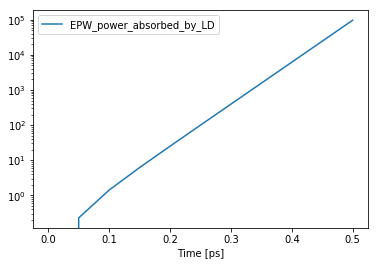

/warwick/desktop/2018/software/MPI/GCC/7.3.0-2.30/OpenMPI/3.1.1/matplotlib/3.0.0-Python-3.6.6/lib/python3.6/site-packages/matplotlib/ticker.py:2241: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  "Data has no positive values, and therefore cannot be "


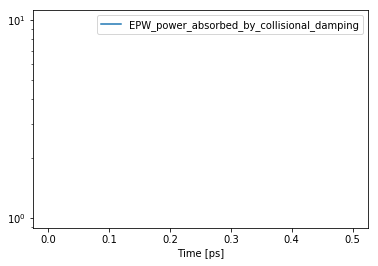

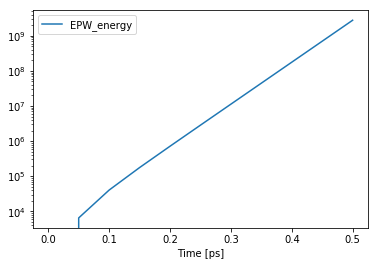

In [826]:
# LW absorption metrics
lpse.plot_metric('EPW_power_absorbed_by_LD',loglin=True)
lpse.plot_metric('EPW_power_absorbed_by_collisional_damping',loglin=True)
lpse.plot_metric('EPW_energy',loglin=True)

In [603]:
# Get known theory results
undampedx = []; undampedy = []
dampedx = []; dampedy = []
with open('ihp_undamped.csv','r') as fp:
  for line in fp:
    lin = line.strip().split(',')
    undampedx.append(float(lin[0]))
    undampedy.append(float(lin[1]))
with open('ihp_landau_damped.csv','r') as fp:
  for line in fp:
    lin = line.strip().split(',')
    dampedx.append(float(lin[0]))
    dampedy.append(float(lin[1]))

0.26630605401415647 0.0076418067943218836 -0.08186457881519688
1.433883037112232 2.556736784782228 -0.19152516139554426
0.2556736784782228 0.16449808953347517
1.433883037112232 2.556736784782228 -0.19152516139554426
0.26980806336097196 0.009437773172380393 -0.08449553210773958
1.2830083982741742 2.3821805427529306 -0.24489227218838158
0.26444599320107487 0.1504681976591171
1.2830083982741742 2.3821805427529306 -0.24489227218838158
0.2732706137472061 0.011204942875422853 -0.08542745985286643
1.1696113831749342 2.2489314949843977 -0.29250178892808504
0.2721714896906531 0.13878446047497492
1.1696113831749342 2.2489314949843977 -0.29250178892808504
0.2766949782133848 0.01292876684815295 -0.08504824626017932
1.0803420264205583 2.1426646710650132 -0.3359430070494798
0.2791201902446479 0.1287799480022299
1.0803420264205583 2.1426646710650132 -0.3359430070494798
0.2800823614626458 0.01459621011121463 -0.08363898602478093


/home/space/phrfqm/lpse-3.2.11/cases/lpse_utils/calc_inputs.py:192: RuntimeWarning: invalid value encountered in log10
  print(f'Permittivity: {abs(perm(om,k_ek))}\n')
/home/space/phrfqm/lpse-3.2.11/cases/lpse_utils/ihp.py:63: RuntimeWarning: invalid value encountered in log10
  print(wavens[2]*dby,freqs[2]/omega_pe,np.log10(LD/omega_ek))
/home/space/phrfqm/lpse-3.2.11/cases/lpse_utils/ihp.py:72: RuntimeWarning: invalid value encountered in sqrt
  gamma0 = k_ek*vos/4*np.sqrt(omega_pe**2/(omega_ek*(omega0-omega_ek)))


1.3889347766478932 -2.5050403141074677 nan
-0.34794756836571755 0.2163216610499279
1.3889347766478932 -2.5050403141074677 nan
0.28343390483330977 0.016195714078268364 -0.08141477551539342
0.9470236439060438 1.9814829982875461 -0.41404164855761216
0.29132626416698276 0.11228920087849185
0.9470236439060438 1.9814829982875461 -0.41404164855761216
0.28675069081559906 0.017717153546061896 -0.07854661213800096
0.8953785425634125 1.9181797667051348 -0.4498771719998639
0.2967876885129106 0.10533403220517219
0.8953785425634125 1.9181797667051348 -0.4498771719998639
0.29003374715660246 0.01915178893850631 -0.07517418532691826
0.8507011577338808 1.863001727268678 -0.4840979906832545
0.30191336193033724 0.09903400522678507
0.8507011577338808 1.863001727268678 -0.4840979906832545
0.29328405060395346 0.020492214361437906 -0.07141385015019598
0.8115428134424787 1.8143116574139588 -0.5169829322504159
0.306752076649442 0.0932834456101556
0.8115428134424787 1.8143116574139588 -0.5169829322504159
0.29650

0.3579480682148416 1.2310108648243698 -1.5020384046565807
0.4080926156586184 0.012844592531957294
0.3579480682148416 1.2310108648243698 -1.5020384046565807
0.3940258113531509 0.012219724721499677 0.010246424649201159
0.3527120560458858 1.224377784411451 -1.5340266215598137
0.4101614815532883 0.011993011540805697
0.3527120560458858 1.224377784411451 -1.5340266215598137
0.3964770283620369 0.011424658313812909 0.00996310513774697
0.34761643237750917 1.2179507728988181 -1.5665923269492512
0.4122101347788179 0.01118217638357213
0.34761643237750917 1.2179507728988181 -1.5665923269492512
0.3989133356654966 0.010652919386440274 0.00963363945694054
0.34265374728190595 1.2117208591624167 -1.5997701277594951
0.4142396501383078 0.010410738515684706
0.34265374728190595 1.2117208591624167 -1.5997701277594951
0.4013349362382863 0.009906545127810652 0.009265955401925709
0.3378170387040635 1.2056797032524174 -1.633596084496078
0.4162510636702044 0.00967741291306741
0.3378170387040635 1.2056797032524174

0.21083278866655672 1.071844699236133 -3.826713127876592
0.48272092100854413 7.19420805828253e-05
0.21083278866655672 1.071844699236133 -3.826713127876592
0.4816859442990636 3.928935595866206e-05 6.302150075991124e-05
0.20788633500883483 1.0696444451941083 -3.9433091334525754
0.48448106098460375 5.520363441564137e-05
0.20788633500883483 1.0696444451941085 -3.9433091334525754
0.4836075462408533 2.945772786479422e-05 4.7584451801097006e-05
0.2049325080595185 1.06748586986543 -4.0661639990231535
0.48623336596640265 4.175233403233863e-05
0.2049325080595185 1.06748586986543 -4.0661639990231535
0.4855127800592291 2.1749734655040183e-05 3.5376597079483825e-05
0.20196628326015864 1.0653649029223764 -4.195901121517824
0.48797664455399864 3.108120979968128e-05
0.20196628326015864 1.0653649029223764 -4.195901121517824
0.48740074517210624 1.578750850491042e-05 2.5853679943954528e-05
0.19898186410259974 1.0632772677634237 -4.333249943766419
0.48970955637599567 2.273466898638313e-05
0.19898186410259

0.028708865919359224 1.001237538719289 -7.545877955255072
0.2567497450000936 7.30519924705535e-09
0.028708865919359224 1.001237538719289 -7.545877955255072
0.2612315200888704 4.1248192428785265e-273 8.220351177155134e-273
0.028084928293945554 1.0011842819338956 -7.553060161665011
0.2612319990121139 7.3108220342817134e-09
0.028084928293945554 1.0011842819338956 -7.553060161665011
0.2656382173509744 4.186652832838908e-285 8.344824008195567e-285
0.027490774751480634 1.0011347037365248 -7.548588233642325
0.26563867660483736 7.511091875663797e-09
0.027490774751480634 1.0011347037365248 -7.548588233642325
0.2699730231399549 2.7017520356367582e-297 5.385874338483617e-297
0.026924001552297263 1.0010883778865114 -7.549630615308261
0.2699734586738544 7.615360290586595e-09
0.026924001552297263 1.0010883778865114 -7.549630615308261
0.27423934502981206 1.09956827950294e-309 2.192247325572157e-309
0.026382466307647817 1.0010449737441132 -7.563213437555031
0.2742397466049276 7.497508406918242e-09
0.0

0.013703634177599244 1.0002817235779522 -7.89186239155191
0.42115629540176797 5.402327460896096e-09
0.013703634177599244 1.0002817235779522 -7.89186239155191
0.4239039611757948 0.0 0.0
0.013528470599017862 1.0002745689779753 -7.881568802081339
0.4239039939579615 5.5679933301038075e-09
0.013528470599017862 1.0002745689779753 -7.881568802081339
0.42663395891851974 0.0 0.0
0.013355262334688336 1.000267584780171 -7.870920130331215
0.42663399133080915 5.7429538168704676e-09
0.013355262334688336 1.000267584780171 -7.870920130331215
0.4293465924245564 0.0 0.0
0.01318388385976086 1.0002607629705336 -7.859661684354825
0.42934662450531047 5.931251894631317e-09
0.01318388385976086 1.0002607629705336 -7.859661684354825
0.4320421880464502 0.0 0.0
0.01301420948284202 1.0002540958234931 -7.847982497666755
0.4320422198344637 6.131174702545085e-09
0.01301420948284202 1.0002540958234931 -7.847982497666755
0.4347210619563414 0.0 0.0
0.012846112636124013 1.0002475758459148 -7.835778619602779
0.43472109348

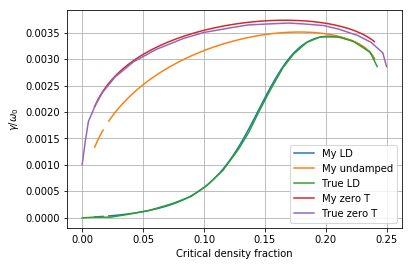

In [782]:
# Compare theory plots
dens,gammas,gamma0s,dks = ihp.srs_theory_curve(lpse,disp=True,verbose=False)
dens0,gammas0,gamma0s0,dks0 = ihp.srs_theory_curve(lpse,Te=0.01,disp=True)
plt.plot(dens,gammas,label='My LD')
plt.plot(dens,gamma0s,label='My undamped')
plt.plot(dampedx,dampedy,label='True LD')
plt.plot(dens0,gammas0,label='My zero T')
plt.plot(undampedx,undampedy,label='True zero T')
plt.xlabel('Critical density fraction')
plt.ylabel(r'$\gamma/\omega_0$')
plt.legend()
plt.grid()
plt.show()

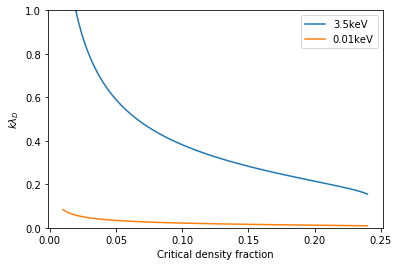

In [574]:
plt.plot(dens,dks,label='3.5keV')
plt.plot(dens,dks0,label='0.01keV')
plt.ylabel(r'$k\lambda_D$')
plt.xlabel('Critical density fraction')
plt.ylim(0,1)
plt.legend()
plt.show()

499.94717084903965
0.14571412428698535 0.14285734966032163


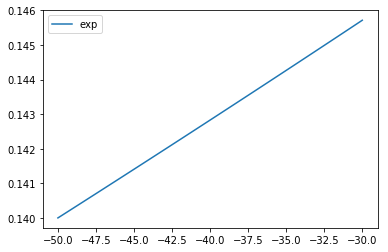

In [575]:
# Exp density profile
xmax = 50; xmin = -50
dx = xmin-xmax
dr = abs(dx)
x = np.linspace(xmin,-30,100)
r = abs(x-xmax)
nmax = 0.171; nmin = 0.14
Ln = dr/np.log(nmax/nmin)
print(Ln)
n = nmax*np.exp(-r/Ln)
print(n[-1],n[50])
# test = np.linspace(0.14,0.17,100)
plt.plot(x,n,label='exp')
# plt.plot(x,test,label='lin')
plt.legend()
plt.show()

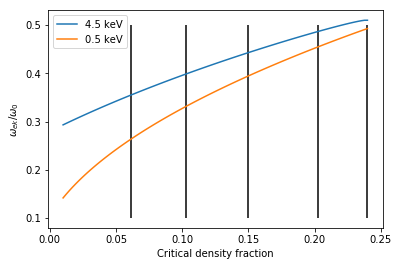

In [576]:
# LW Frequency curves
dens = np.linspace(0.01,0.24,100)
T = 4.5
freqh = ihp.lw_freq_curve(lpse,dens,T=T)
plt.plot(dens,freqh,label = f'{T} keV')
T = 0.5
freqc = ihp.lw_freq_curve(lpse,dens,T=T)
plt.plot(dens,freqc,label = f'{T} keV')
plt.xlabel('Critical density fraction')
plt.ylabel(r'$\omega_{ek}/\omega_0$')

# 10/20% bracket around central frequency
freqq = freqh
den = 0.15; mults = np.linspace(0.80,1.2,5)
denid = np.argmin(abs(dens-den))
freqcen = freqq[denid]
freqbrc = freqcen*mults
freqids = np.array([np.argmin(abs(freqq-freqbrc[i])) for i in range(5)])
denbrc = dens[freqids]
for i in denbrc:
  plt.vlines(i,0.1,0.5)
plt.legend()
plt.show()

31.750000000000057


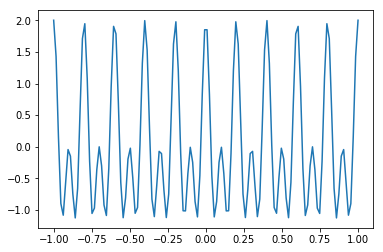

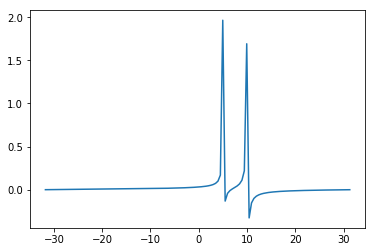

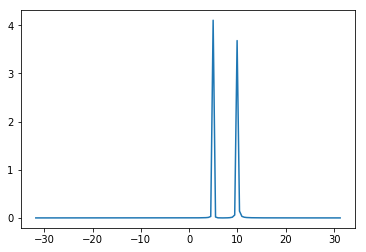

In [140]:
import pyfftw

k = 10
N = 128
wave = lambda x,k: np.exp(2*np.pi*1j*k*x)
x = np.linspace(-1,1,N)
dx = x[1]-x[0]
kr = (np.arange(N)-N/2)/(N*dx)
y = wave(x,10) + wave(x,5)
nyq = 0.5/dx
print(nyq)
plt.plot(x,y)
plt.show()
fy = np.fft.fftshift(np.fft.fft(y))*dx
plt.plot(kr,np.real(fy))
plt.show()
P = fy*np.conjugate(fy)
plt.plot(kr,P)
plt.show()

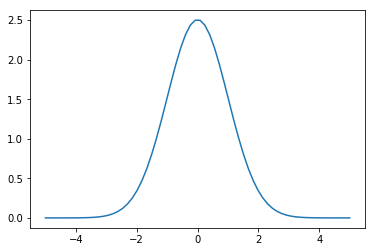

3.1499999999999937
[-3.15      -3.0515625 -2.953125  -2.8546875 -2.75625   -2.6578125
 -2.559375  -2.4609375 -2.3625    -2.2640625 -2.165625  -2.0671875
 -1.96875   -1.8703125 -1.771875  -1.6734375 -1.575     -1.4765625
 -1.378125  -1.2796875 -1.18125   -1.0828125 -0.984375  -0.8859375
 -0.7875    -0.6890625 -0.590625  -0.4921875 -0.39375   -0.2953125
 -0.196875  -0.0984375  0.         0.0984375  0.196875   0.2953125
  0.39375    0.4921875  0.590625   0.6890625  0.7875     0.8859375
  0.984375   1.0828125  1.18125    1.2796875  1.378125   1.4765625
  1.575      1.6734375  1.771875   1.8703125  1.96875    2.0671875
  2.165625   2.2640625  2.3625     2.4609375  2.559375   2.6578125
  2.75625    2.8546875  2.953125   3.0515625]
[-3.15      -3.0515625 -2.953125  -2.8546875 -2.75625   -2.6578125
 -2.559375  -2.4609375 -2.3625    -2.2640625 -2.165625  -2.0671875
 -1.96875   -1.8703125 -1.771875  -1.6734375 -1.575     -1.4765625
 -1.378125  -1.2796875 -1.18125   -1.0828125 -0.984375  -0.88593

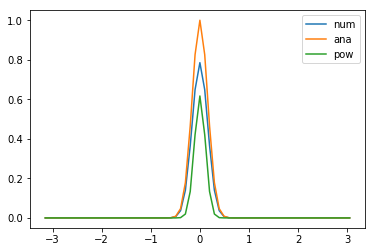

In [110]:
N = 64
t = np.linspace(-5,5,N)
sigma = 1
gauss = lambda t: np.sqrt(2*np.pi*sigma**2)*np.exp(-t**2/(2*sigma**2))
y = gauss(t)
plt.plot(t,y)
plt.show()
anaft = lambda f: np.exp(-2*np.pi**2*sigma**2*f**2)
dt = t[1]-t[0]
nyq = 1/(2*dt)
df = 2*nyq/N
print(nyq)
numft = np.fft.fftshift(np.fft.fft(y,norm='ortho'))*dt
f = np.fft.fftshift(np.fft.fftfreq(N))/dt
kr = (np.arange(N)-N/2)/(N*dt)
print(f)
print(kr)
P = numft*np.conjugate(numft)
plt.plot(f,np.abs(numft),label='num')
plt.plot(f,anaft(f),label='ana')
plt.plot(f,P,label='pow')
plt.legend()
plt.show()